# 00 Installing Torch Modules

In [1]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     |████████████████████████████████| 7.9 MB 14.4 MB/s 
     |████████████████████████████████| 3.5 MB 2.0 MB/s 


In [8]:
import torch
from torch_geometric.datasets import EllipticBitcoinDataset
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.data import Data, DataLoader

#import umap
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm.notebook import tqdm
import time
import seaborn as sns
import networkx as nx
from sklearn.metrics import accuracy_score


# 01 LOADING DATA
BTC transactions data for classification of illicit and lit activities

In [9]:
dataset = EllipticBitcoinDataset("Data")
df_classes = pd.read_csv("/content/Data/raw/elliptic_txs_classes.csv") 
df_edges = pd.read_csv("/content/Data/raw/elliptic_txs_edgelist.csv")
df_features = pd.read_csv("/content/Data/raw/elliptic_txs_features.csv", header=None)

In [ ]:
"""
colNames1 = {1: "Time step"}
colNames2 = {str(ii+2): "Local_feature_" + str(ii+1) for ii in range(93)}
colNames3 = {str(ii+95): "Aggregate_feature_" + str(ii+1) for ii in range(72)}

colNames = dict(colNames1, **colNames2, **colNames3 )
colNames = {int(jj): item_kk for jj,item_kk in colNames.items()}

#df_classes.loc[df_classes['class'] == 'unknown', 'class'] = 3

df_features = df_features.rename(columns=colNames)


df_classes['class'] = df_classes['class'].map({'unknown': 2, '1':1, '2':0})
# Merge Class and features
df_class_feature = pd.merge(df_classes, df_features )
classified_idx = df_class_feature['class'].loc[df_class_feature['class']!=2].index
unclassified_idx = df_class_feature['class'].loc[df_class_feature['class']==2].index

df_X =df_class_feature.drop(df_class_feature.loc[df_class_feature['class']==2].index, inplace=False)

train_features = df_X.drop(columns = ["txId","class"]).reset_index(drop=True)
orig_labels = df_X['class'].reset_index(drop=True)

print('Shape of classes', df_classes.shape)
print('Shape of edges', df_edges.shape)
print('Shape of features', df_features.shape)
"""

### Processing necessary data

In [10]:

df_classes = pd.read_csv("/content/Data/raw/elliptic_txs_classes.csv") 
df_edges = pd.read_csv("/content/Data/raw/elliptic_txs_edgelist.csv")
df_features = pd.read_csv("/content/Data/raw/elliptic_txs_features.csv", header=None)

df_classes['class'] = df_classes['class'].map({'unknown': 2, '1':1, '2':0})

# merging dataframes
df_merge = df_features.merge(df_classes, how='left', right_on="txId", left_on=0)
df_merge = df_merge.sort_values(0).reset_index(drop=True)
colNames = {1: "Time step"}
df_merge = df_merge.rename(columns=colNames)

classified = df_merge.loc[df_merge['class'].loc[df_merge['class']!=2].index].drop('txId', axis=1)
unclassified = df_merge.loc[df_merge['class'].loc[df_merge['class']==2].index].drop('txId', axis=1)
print(f"classified {classified.shape}")
# storing classified unclassified nodes seperatly for training and testing purpose
classified_edges = df_edges.loc[df_edges['txId1'].isin(classified[0]) & df_edges['txId2'].isin(classified[0])]
unclassifed_edges = df_edges.loc[df_edges['txId1'].isin(unclassified[0]) | df_edges['txId2'].isin(unclassified[0])]

# all nodes in data
nodes = df_merge[0].values
map_id = {j:i for i,j in enumerate(nodes)} # mapping nodes to indexes

edges = df_edges.copy()
edges.txId1 = edges.txId1.map(map_id)
edges.txId2 = edges.txId2.map(map_id)
edges = edges.astype(int)

edge_index = np.array(edges.values).T

edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous()
weights = torch.tensor([1]* edge_index.shape[1] , dtype=torch.double)
print(edge_index.shape)

# maping txIds to corresponding indexes, to pass node features to the model
node_features = df_merge.drop(['txId'], axis=1).copy()
node_features[0] = node_features[0].map(map_id)
classified_idx = node_features['class'].loc[node_features['class']!=2].index
unclassified_idx = node_features['class'].loc[node_features['class']==2].index
# replace unkown class with 0, to avoid having 3 classes, this data/labels never used in training
#node_features['class'] = node_features['class'].replace(2, 0) 

df_data = node_features

labels = node_features['class'].values
df_feat = node_features.drop([0, 'class'], axis=1)
nodes_features_only = np.array(df_feat.values, dtype=np.double)
node_features = torch.tensor(nodes_features_only, dtype=torch.double)
nodes_features_only.shape,labels.shape

df_class = pd.DataFrame(labels, columns=['class'])
labelmap  = {2:"unknown", 0:"licit", 1:"illicit"}
df_class['class'] = df_class['class'].map(labelmap)

# converting data to PyGeometric graph data format
data_train = Data(x=node_features, edge_index=edge_index, edge_attr=weights,
                               y=torch.tensor(labels, dtype=torch.double)) #, adj= torch.from_numpy(np.array(adj))


classified (46564, 168)
torch.Size([2, 234355])


In [11]:
nodes_features_only.shape

(203769, 166)

Text(0.5, 1.0, 'BTC Classes')

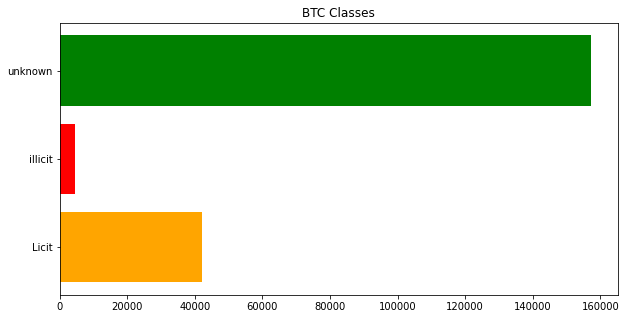

In [12]:
###count of classes

%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]
group_class = df_data.groupby(["class"]).size()
plt.barh(['Licit',"illicit",'unknown'],group_class, color=['orange', 'r', 'g'] )
plt.title('BTC Classes')

Text(0.5, 1.0, 'number of transactions by timestep')

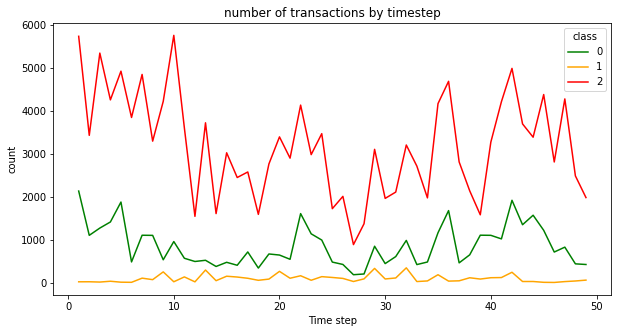

In [13]:
group_class_feature = df_data.groupby(['Time step', 'class']).count()
group_class_feature = group_class_feature[0].reset_index().rename(columns={0: 'count'})
sns.lineplot(x='Time step', y='count', hue='class', data = group_class_feature, palette=['g', 'orange', 'r'] )
plt.title("number of transactions by timestep")

In [16]:
df_merge

,0,Time step,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,txId,class
0,1076,48,-0.168500,0.270909,-0.091383,-0.046932,-0.043875,-0.029140,-0.061584,-0.163591,...,1.461330,1.461369,0.018279,0.470019,1.216796,1.151607,1.519700,1.521399,1076,2
1,2534,6,-0.170834,-0.131425,1.018602,0.028105,0.055376,0.054722,-0.061584,-0.163572,...,0.955101,0.459257,-0.098889,-0.087490,-0.099080,-0.122137,-0.379970,-0.379288,2534,0
2,3181,34,1.305212,-0.210553,-1.756361,-0.121970,97.300650,-0.113002,-0.061584,1.348765,...,0.059948,0.113967,-0.098889,1.969527,0.037532,-0.131010,0.006994,0.017772,3181,0
3,3321,1,-0.169615,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160199,...,0.241128,0.241406,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,3321,2
4,3889,48,-0.086232,-0.101835,-0.646376,-0.121970,17.046997,-0.113002,-0.061584,-0.074885,...,0.082065,0.114773,-0.098889,8.948005,1.024948,-0.009570,-0.080708,-0.123601,3889,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203764,403203785,28,-0.172978,-0.172527,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,-0.163640,...,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,403203785,2
203765,403234712,28,-0.172669,-0.158783,-1.201369,-0.121970,-0.063725,-0.113002,-0.061584,-0.163323,...,0.241128,0.241406,-0.216057,-0.125939,-0.131155,-0.269818,-0.120613,-0.119792,403234712,2
203766,403234715,28,-0.172669,-0.158783,-1.201369,-0.121970,-0.063725,-0.113002,-0.061584,-0.163323,...,0.241128,0.241406,-0.216057,-0.125939,-0.131155,-0.269818,-0.120613,-0.119792,403234715,2
203767,403235564,28,-0.172669,-0.158783,-1.201369,-0.121970,-0.063725,-0.113002,-0.061584,-0.163323,...,0.241128,0.241406,-0.216057,-0.125939,-0.131155,-0.269818,-0.120613,-0.119792,403235564,2


In [18]:
df_edges

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206
...,...,...
234350,158365409,157930723
234351,188708874,188708879
234352,157659064,157659046
234353,87414554,106877725


In [21]:
(df_merge['Time step'] == 48)

0          True
1         False
2         False
3         False
4          True
          ...  
203764    False
203765    False
203766    False
203767    False
203768    False
Name: Time step, Length: 203769, dtype: bool

In [ ]:
(df_merge['Time step'] == timesteps)

In [22]:
df_merge.loc[(df_merge['Time step'] == timesteps) & (df_merge['class'] == 0), 'txId']

102          163032
403         1009583
404         1009587
405         1009594
406         1011690
            ...    
106537    168183083
106540    168193729
106545    168201956
106549    168205985
106551    168207443
Name: txId, Length: 845, dtype: int64

## dataview of graphs

No handles with labels found to put in legend.


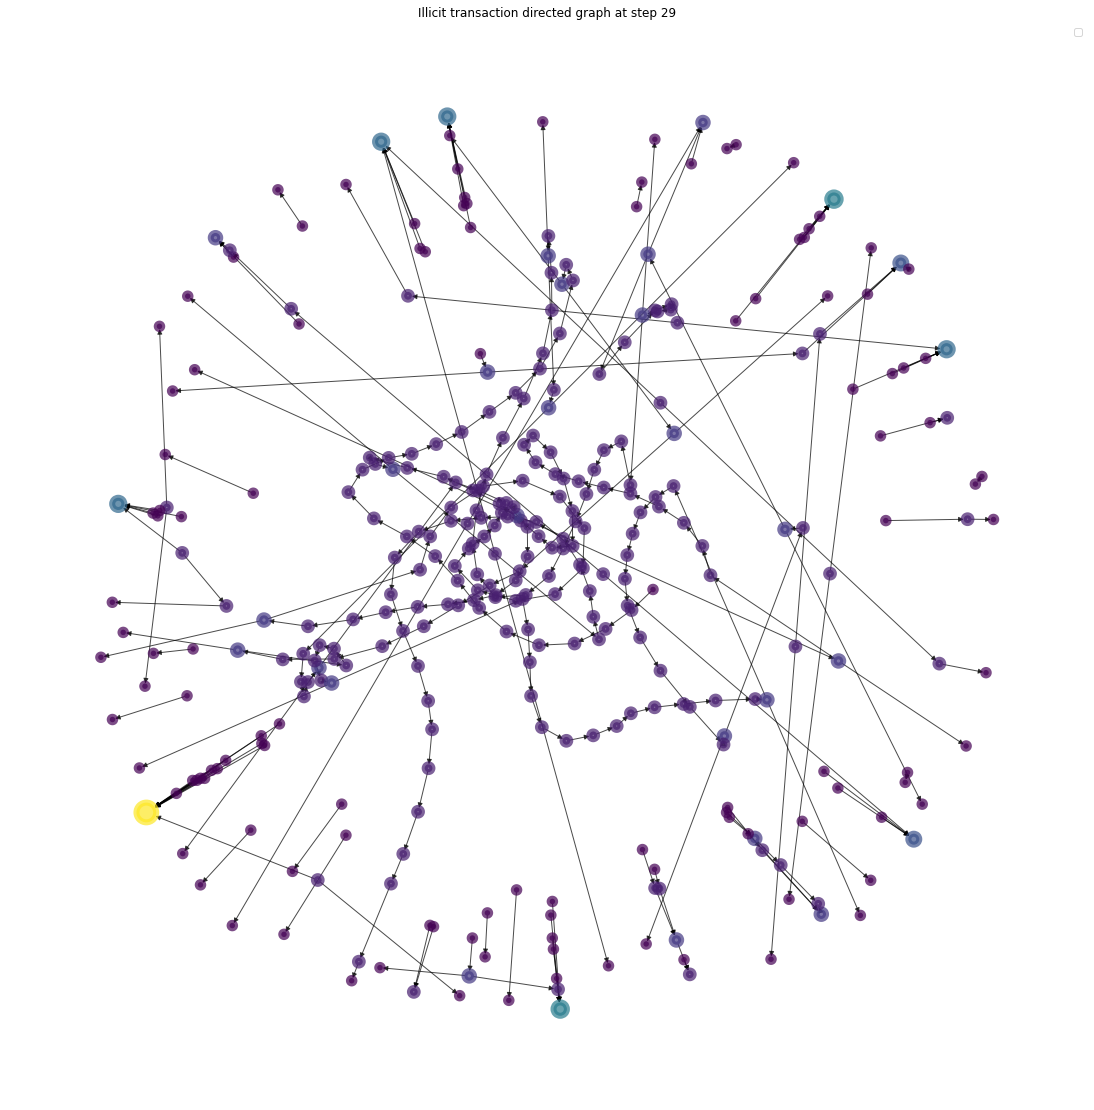

In [24]:
timesteps = 29
ilicit_ids = df_merge.loc[(df_merge['Time step'] == timesteps) & (df_merge['class'] == 1), 'txId']
ilicit_edges = df_edges.loc[df_edges['txId1'].isin(ilicit_ids)]

graph = nx.from_pandas_edgelist(ilicit_edges, source = 'txId1', target = 'txId2', 
                                 create_using = nx.DiGraph())

degrees = [val*30 for (node, val) in graph.degree()]
nodes = graph.nodes()

n_color = np.asarray([degrees[n] for n in range(len(nodes))])


plt.figure(1,figsize=(15,15)) 
seed = 31

pos = nx.spring_layout(graph, seed=seed)
nx.draw(graph, with_labels=False,alpha=0.7, pos=pos,node_size=degrees,linewidths=6,node_color=n_color, cmap='viridis')
plt.title("Illicit transaction directed graph at step 29")
plt.legend()
plt.tight_layout()

In [ ]:
##ilicit timeframe pattern

import os 
    
# path 
path = '/content/graphvis'

try: 
    os.mkdir(path) 
except OSError as error: 
    print(error)  


plt.rcParams["figure.figsize"] = (15,15)

for i in range(48):
    timesteps = i
    ilicit_ids = df_class_feature.loc[(df_class_feature['Time step'] == timesteps) & (df_class_feature['class'] == '1'), 'txId']
    ilicit_edges = df_edgelist.loc[df_edgelist['txId1'].isin(ilicit_ids)]

    graph = nx.from_pandas_edgelist(ilicit_edges, source = 'txId1', target = 'txId2', 
                                    create_using = nx.DiGraph())

    degrees = [val*20 for (node, val) in graph.degree()]
    nodes = graph.nodes()

    n_color = np.asarray([degrees[n] for n in range(len(nodes))])
    seed = 31

    pos = nx.spring_layout(graph, seed=seed)
    nx.draw(graph, with_labels=False,alpha=0.7, pos=pos,node_size=degrees,linewidths=6,node_color=n_color, cmap='viridis')
    
    plt.savefig(f'{path}/{timesteps:03}.png',dpi=150)
    #plt.show()
    



Text(0.5, 1.0, 'Licit transaction directed graph at step 29')

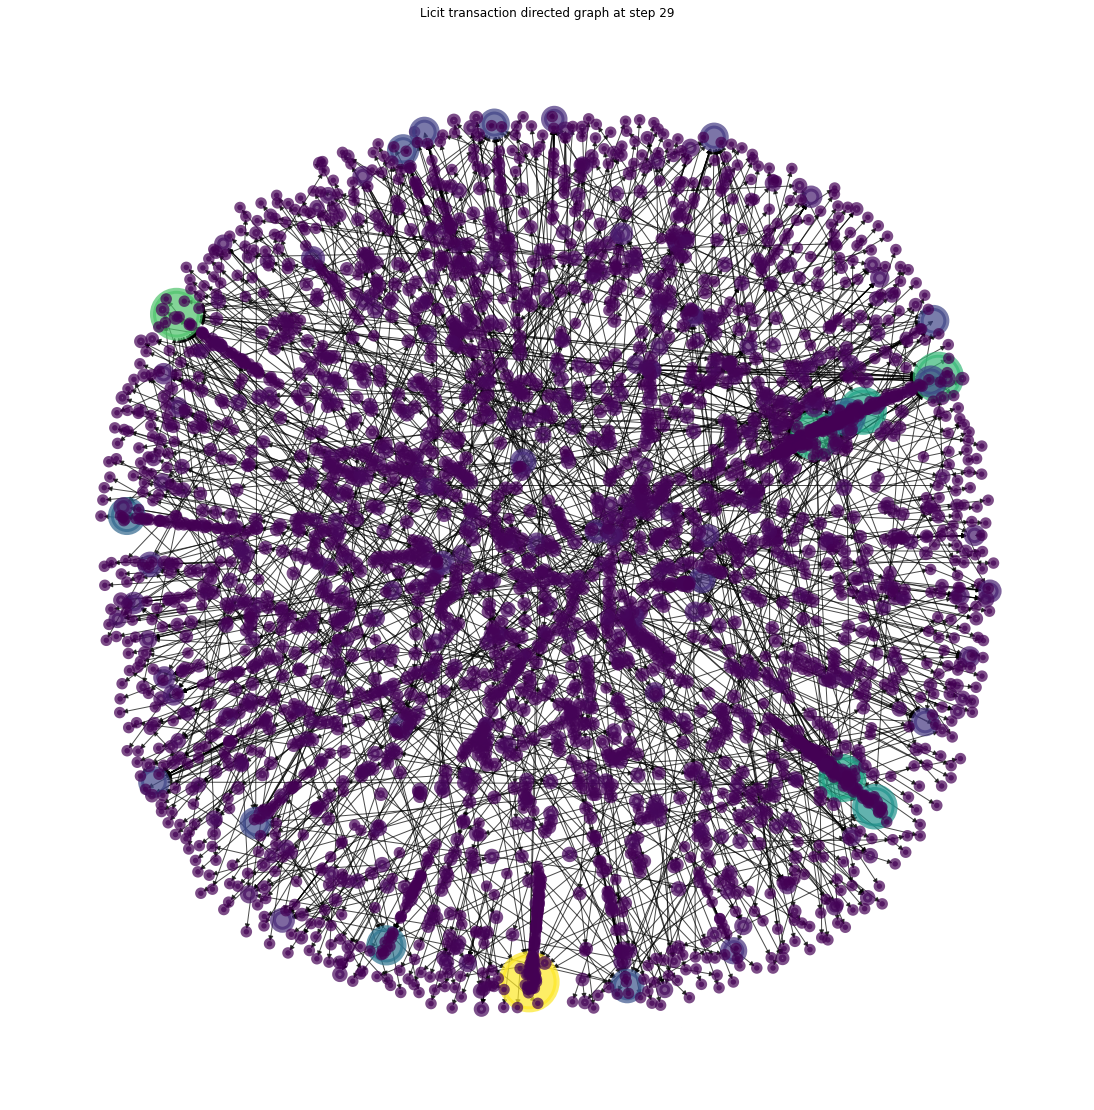

In [28]:
licit_ids = df_merge.loc[(df_merge['Time step'] == timesteps) & (df_merge['class'] == 2), 'txId']
licit_edges = df_edges.loc[df_edges['txId1'].isin(licit_ids)]

graph = nx.from_pandas_edgelist(licit_edges, source = 'txId1', target = 'txId2', 
                                 create_using = nx.DiGraph())
degrees = [val*30 for (node, val) in graph.degree()]
nodes = graph.nodes()

n_color = np.asarray([degrees[n] for n in range(len(nodes))])
plt.figure(1,figsize=(15,15)) 
seed = 31

pos = nx.spring_layout(graph, seed=seed)
nx.draw(graph, with_labels=False,alpha=0.7, pos=pos,node_size=degrees,linewidths=6,node_color=n_color, cmap='viridis')
plt.title("Licit transaction directed graph at step 29")

In [ ]:
##licit timeframe pattern

import os 
    
# path 
path = '/content/graphvislicit'

try: 
    os.mkdir(path) 
except OSError as error: 
    print(error)  


plt.rcParams["figure.figsize"] = (15,15)

for i in range(48):
    timesteps = i
    ilicit_ids = df_class_feature.loc[(df_class_feature['Time step'] == timesteps) & (df_class_feature['class'] == '2'), 'txId']
    ilicit_edges = df_edgelist.loc[df_edgelist['txId1'].isin(ilicit_ids)]

    graph = nx.from_pandas_edgelist(ilicit_edges, source = 'txId1', target = 'txId2', 
                                    create_using = nx.DiGraph())

    degrees = [val*10 for (node, val) in graph.degree()]
    nodes = graph.nodes()

    n_color = np.asarray([degrees[n] for n in range(len(nodes))])
    seed = 31

    pos = nx.spring_layout(graph, seed=seed)
    nx.draw(graph, with_labels=False,alpha=0.7, pos=pos,node_size=degrees,linewidths=6,node_color=n_color, cmap='viridis')
    
    plt.savefig(f'{path}/{timesteps:03}.png',dpi=150)

In [ ]:
# @title ### **Create video from specific folder**

filepath = 'licitviz.mp4' #@param {type:"string"}
image_path = '/content/graphvislicit' #@param{type:"string"}
!rm {filepath}
fps =  2#@param {type:"number"}
output = image_path

!ffmpeg -r {fps} -pattern_type glob -i "{output + '/*.png'}"  -ss 0 -crf 15 -vcodec libx264 -pix_fmt yuv420p {filepath} -hide_banner -loglevel error

rm: cannot remove 'licitviz.mp4': No such file or directory


In [ ]:
from IPython.display import HTML
from base64 import b64encode

# @title ### **Create video from specific folder**

filepath = 'licitviz.mp4' #@param {type:"string"}
def show_video(video_path, video_width = 1000):
   
  video_file = open(video_path, "r+b").read()
 
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")
 
show_video('illicitviz.mp4')

# 02 CLUSTERING
---



1.   KMeans
2.   EM (expectation maximization)



## 00- Data modification 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection,SparseRandomProjection
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from collections import Counter
from collections import defaultdict
from datetime import datetime
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import adjusted_mutual_info_score,adjusted_rand_score,homogeneity_score,completeness_score,v_measure_score


In [ ]:
df_data

,0,Time step,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,class
0,0,48,-0.168500,0.270909,-0.091383,-0.046932,-0.043875,-0.029140,-0.061584,-0.163591,...,-0.039637,1.461330,1.461369,0.018279,0.470019,1.216796,1.151607,1.519700,1.521399,2
1,1,6,-0.170834,-0.131425,1.018602,0.028105,0.055376,0.054722,-0.061584,-0.163572,...,0.379357,0.955101,0.459257,-0.098889,-0.087490,-0.099080,-0.122137,-0.379970,-0.379288,0
2,2,34,1.305212,-0.210553,-1.756361,-0.121970,97.300650,-0.113002,-0.061584,1.348765,...,1.590664,0.059948,0.113967,-0.098889,1.969527,0.037532,-0.131010,0.006994,0.017772,0
3,3,1,-0.169615,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160199,...,-0.500080,0.241128,0.241406,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,2
4,4,48,-0.086232,-0.101835,-0.646376,-0.121970,17.046997,-0.113002,-0.061584,-0.074885,...,0.362510,0.082065,0.114773,-0.098889,8.948005,1.024948,-0.009570,-0.080708,-0.123601,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203764,203764,28,-0.172978,-0.172527,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,-0.163640,...,-0.600999,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,2
203765,203765,28,-0.172669,-0.158783,-1.201369,-0.121970,-0.063725,-0.113002,-0.061584,-0.163323,...,-0.626229,0.241128,0.241406,-0.216057,-0.125939,-0.131155,-0.269818,-0.120613,-0.119792,2
203766,203766,28,-0.172669,-0.158783,-1.201369,-0.121970,-0.063725,-0.113002,-0.061584,-0.163323,...,-0.626229,0.241128,0.241406,-0.216057,-0.125939,-0.131155,-0.269818,-0.120613,-0.119792,2
203767,203767,28,-0.172669,-0.158783,-1.201369,-0.121970,-0.063725,-0.113002,-0.061584,-0.163323,...,-0.626229,0.241128,0.241406,-0.216057,-0.125939,-0.131155,-0.269818,-0.120613,-0.119792,2


In [ ]:
orig_labels = labels
train_features = nodes_features_only

In [ ]:
scaler = StandardScaler()
scaler.fit(train_features)
scaler.mean_
scaler.transform(train_features)

array([[ 1.59213208, -0.16849973,  0.27090894, ...,  1.15160746,
         1.51969962,  1.52139948],
       [-1.176101  , -0.17083402, -0.13142464, ..., -0.12213701,
        -0.37996967, -0.37928769],
       [ 0.66938772,  1.30521167, -0.21055258, ..., -0.13101025,
         0.00699431,  0.0177724 ],
       ...,
       [ 0.27392585, -0.17266855, -0.15878252, ..., -0.26981753,
        -0.12061341, -0.11979246],
       [ 0.27392585, -0.17266855, -0.15878252, ..., -0.26981753,
        -0.12061341, -0.11979246],
       [ 0.27392585, -0.14329174, -0.15878252, ..., -0.09752359,
        -0.12061341, -0.11979246]])

In [ ]:
def cluster_measures(orig_labels,preds):
  measures = {"homogeneity":homogeneity_score(orig_labels,preds),
              "completeness":completeness_score(orig_labels,preds),
              "v_measure":v_measure_score(orig_labels,preds),
              "adjusted_rand_score":adjusted_rand_score(orig_labels,preds),
              "adjusted_mutual_info_score":adjusted_mutual_info_score(orig_labels,preds)}
  return measures

In [ ]:
def create_plotvals(results,title):
  kk = defaultdict(list)
  if title == 'kmeans':
    typmeasure = 'inertia'
  if title == 'em':
    typmeasure = "bic"

  inertias = defaultdict(list)
  times = defaultdict(list)
  for k in results.keys():
    measures = results[k]['measures']
    inertias[k].append(results[k][typmeasure])
    times[k].append(results[k]['time'])

    for m in measures.keys():
      kk[m].append(measures[m])

  df = pd.DataFrame.from_dict(kk, orient='index').T

  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))

  
  max = df.max(numeric_only=True).max()
  min = df.min(numeric_only=True).min()

  axes[0].plot(list(inertias.keys()), list(inertias.values()))
  axes[0].set_xlabel(r'Number of clusters *k*')
  axes[0].set_title(typmeasure)
  axes[0].set_ylabel('Sum of squared distance')
  
  

  axes[1].plot(list(times.keys()),list(times.values()))
  axes[1].set_xlabel(r'Number of clusters *k*')
  axes[1].set_ylabel('Time in Seconds')
  axes[1].set_title('Time')
  

  axes[2] = sns.lineplot(data = df,alpha=0.8,markers=True, dashes=False,markersize=14)
  axes[2].set(xlabel = r'Number of clusters *k*', ylabel = "Score")
  axes[2].set_xticks(range(len(ks)))
  axes[2].set_xticklabels([str(x) for x in ks])
  axes[2].set_title(title)
  fig.tight_layout()
  

## a. Kmeans

In [ ]:
#kmeans
ks = [2,4,5,7,10,20]

kmdict = defaultdict(dict)

for k in ks:
  print(k)
  startTime = time.time()
  km = KMeans(n_clusters=k, random_state=0).fit(train_features)
  preds = km.predict(train_features)
  centroids = km.cluster_centers_
  
  endTime = time.time()
  totaltime = endTime - startTime

  clustermeasures = cluster_measures(orig_labels,preds)

  kmdict[k] ={"preds":preds, 
              "inertia":km.inertia_,  
              "centroid":centroids,
              "time":totaltime,
              "measures": clustermeasures}

2
4
5
7
10
20


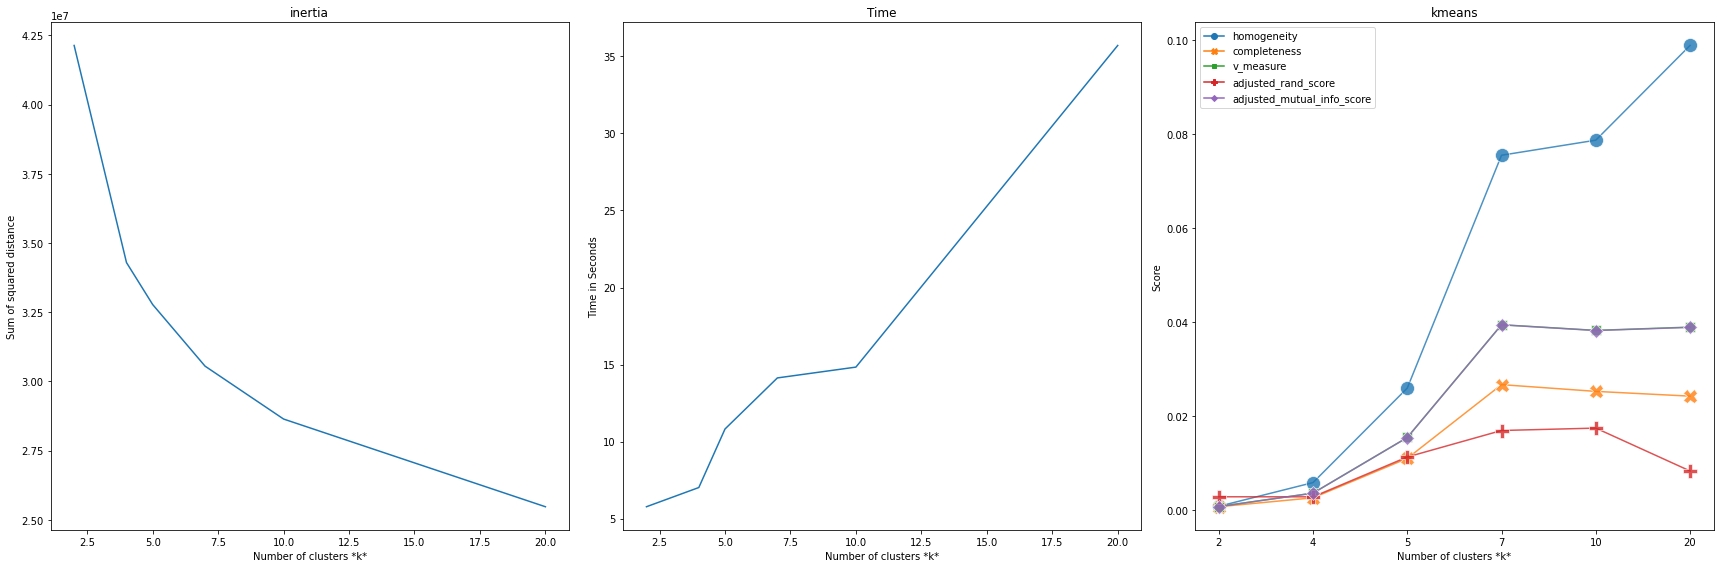

In [ ]:
create_plotvals(results=kmdict,title='kmeans')

## b. EM(expectation maximization) using Gaussian Mixture

In [ ]:
ks = [2,4,5,7,10,20]

gmpreds = []
gmtimes = []

gm_bic= []
gm_score=[]
gmdict = defaultdict(dict)
for k in ks:
    print(k)
    startTime = time.time()
    gm = GaussianMixture(n_components=k).fit(train_features)
    preds = gm.predict(train_features)
    bic = -gm.bic(train_features)
    score = gm.score(train_features)

    endTime = time.time()
    totaltime = endTime-startTime
    
    clustermeasures = cluster_measures(orig_labels,preds)

    gmdict[k] ={"preds":preds, 
                "bic":bic,  
                "time":totaltime,
                "measures": clustermeasures}



2
4
5
7
10
20


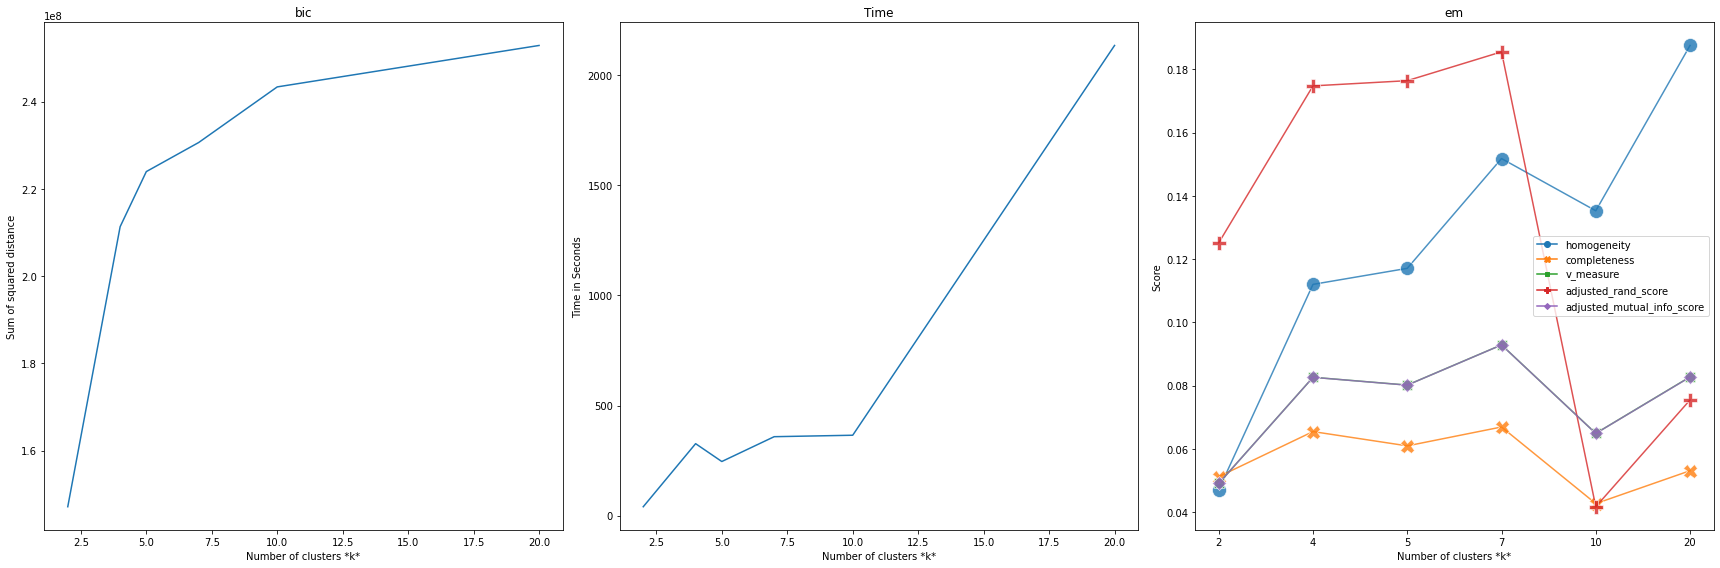

In [ ]:
create_plotvals(results=gmdict,title='em')

In [ ]:
from google.colab import drive
#@title 1.2 Prepare Folders
#@markdown If you connect your Google Drive, you can save the final image of each run on your drive.

google_drive = True #@param {type:"boolean"}

#@markdown Click here if you'd like to save the diffusion model checkpoint file to (and/or load from) your Google Drive:
yes_please = True #@param {type:"boolean"}

if google_drive is True:
  drive.mount('/content/drive')
  root_path = '/content/drive/MyDrive/Archi_Dataset/Data'
else:
  root_path = '/content'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 03 Dimensionality Reduction



---



1.   PCA
2.   ICA
3.   RP (Randomized Projections)
4.   RFE (Recursive Feature Elimination)

## a.PCA

In [ ]:
#features
train_features

array([[ 4.80000000e+01, -1.68499734e-01,  2.70908938e-01, ...,
         1.15160746e+00,  1.51969962e+00,  1.52139948e+00],
       [ 6.00000000e+00, -1.70834019e-01, -1.31424638e-01, ...,
        -1.22137014e-01, -3.79969668e-01, -3.79287690e-01],
       [ 3.40000000e+01,  1.30521167e+00, -2.10552579e-01, ...,
        -1.31010246e-01,  6.99430893e-03,  1.77724049e-02],
       ...,
       [ 2.80000000e+01, -1.72668553e-01, -1.58782524e-01, ...,
        -2.69817533e-01, -1.20613407e-01, -1.19792460e-01],
       [ 2.80000000e+01, -1.72668553e-01, -1.58782524e-01, ...,
        -2.69817533e-01, -1.20613407e-01, -1.19792460e-01],
       [ 2.80000000e+01, -1.43291742e-01, -1.58782524e-01, ...,
        -9.75235938e-02, -1.20613407e-01, -1.19792460e-01]])

In [ ]:
def kmeanswrap(train_features,orig_labels):
  #kmeans
  ks = [2,5,10,20]

  kmdict = defaultdict(dict)

  for k in ks:
    print(k)
    startTime = time.time()
    km = KMeans(n_clusters=k, random_state=0).fit(train_features)
    preds = km.predict(train_features)
    centroids = km.cluster_centers_
    
    endTime = time.time()
    totaltime = endTime - startTime

    clustermeasures = cluster_measures(orig_labels,preds)

    kmdict[k] ={"preds":preds, 
                "inertia":km.inertia_,  
                "centroid":centroids,
                "time":totaltime,
                "measures": clustermeasures}
  return kmdict

def emwrap(train_features,orig_labels):
  ks = [2,5,10,20]

  gmpreds = []
  gmtimes = []

  gm_bic= []
  gm_score=[]
  gmdict = defaultdict(dict)
  for k in ks:
      print(k)
      startTime = time.time()
      gm = GaussianMixture(n_components=k).fit(train_features)
      preds = gm.predict(train_features)
      bic = -gm.bic(train_features)
      score = gm.score(train_features)

      endTime = time.time()
      totaltime = endTime-startTime
      
      clustermeasures = cluster_measures(orig_labels,preds)

      gmdict[k] ={"preds":preds, 
                  "bic":bic,  
                  "time":totaltime,
                  "measures": clustermeasures}
  return gmdict

In [ ]:
orig_labels = pd.DataFrame(orig_labels,columns=['class'])
orig_labels

,class
0,2
1,0
2,0
3,2
4,2
...,...
203764,2
203765,2
203766,2
203767,2


In [ ]:

PCA_components = [2,10,20,50]

data_PCA = PCA(random_state=0)
data_eigen = data_PCA.fit(train_features)
data_eigenvalues = data_eigen.explained_variance_

pca_results = defaultdict(dict)

for PCA_comp in PCA_components :
    print(PCA_comp)
    _PCA = PCA(n_components=PCA_comp,random_state=0)
    _PCA_data = _PCA.fit_transform(train_features)

    print(_PCA.explained_variance_ratio_)
    print(_PCA_data.shape)
    print(_PCA.explained_variance_)

    _data_PCA_df = pd.DataFrame(data = _PCA_data)
    _data_PCA_df_labels = pd.concat([_data_PCA_df,pd.DataFrame(orig_labels,columns=['class'])],axis=1)
        
    kmeansdict = kmeanswrap(_data_PCA_df,orig_labels)
    emdict = emwrap(_data_PCA_df,orig_labels)

    pca_results[PCA_comp] ={"data":_data_PCA_df_labels, "var_ratio":_PCA.explained_variance_ratio_, 
                            "comps":_PCA.components_, "var":_PCA.explained_variance_,
                            "mean":_PCA.mean_,
                            "kmean":kmeansdict,
                            "em":emdict}

root_path = '/content/drive/MyDrive/Archi_Dataset/Data'
pckpath = os.path.join(root_path,"dataset_a_pca.pickle")
with open(pckpath, 'wb') as handle:
    pickle.dump(pca_results, handle, protocol=pickle.HIGHEST_PROTOCOL)  

    

2
[0.60262877 0.04367285]
(203769, 2)
[238.15621062  17.25931774]
2
5
10
20
2
5
10
20
10
[0.60262877 0.04367285 0.02329886 0.01916602 0.01692404 0.01640794
 0.01517127 0.01256603 0.01168225 0.01119395]
(203769, 10)
[238.15621062  17.25931774   9.20760592   7.57432591   6.68830526
   6.48434347   5.99561901   4.96603787   4.61677481   4.42379803]
2
5
10
20
2
5
10
20
20
[0.60262877 0.04367285 0.02329886 0.01916601 0.01692391 0.01640792
 0.01517092 0.01256595 0.01168167 0.01119355 0.01058123 0.00930613
 0.0088821  0.00841262 0.0073653  0.00722415 0.00703255 0.00648951
 0.0063987  0.00612735]
(203769, 20)
[238.15621062  17.25931773   9.20760437   7.57432249   6.68825564
   6.48433699   5.99548174   4.96600888   4.61654332   4.42364292
   4.18165388   3.67774281   3.51016504   3.32463109   2.91073533
   2.85495014   2.7792326    2.56462449   2.5287363    2.4215023 ]
2
5
10
20
2
5
10
20
50
[0.60262877 0.04367285 0.02329886 0.01916602 0.01692404 0.01640794
 0.01517127 0.01256608 0.01168233 0.

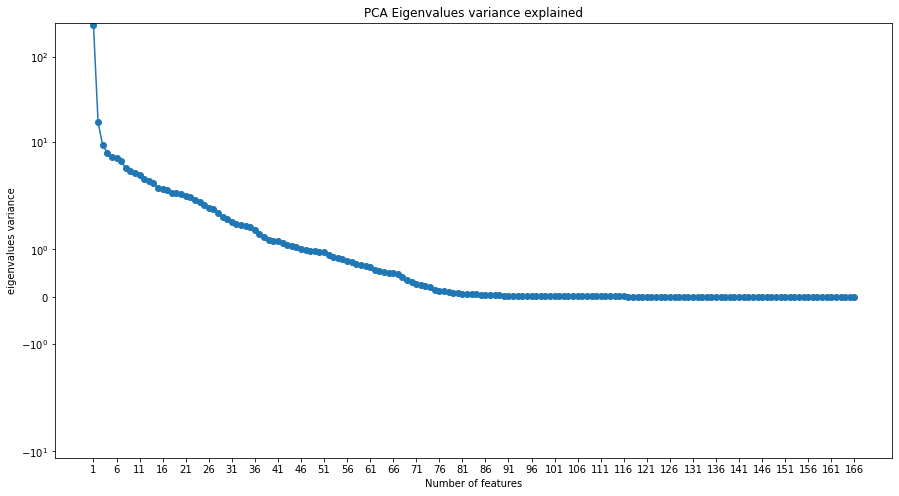

In [ ]:
# plot pca
featsize = np.arange(1,data_eigenvalues.shape[0]+1)


plt.figure(figsize=(15, 8))
plt.plot(featsize, data_eigenvalues, '-o')
plt.xlabel(r'Number of features')
plt.ylabel('eigenvalues variance');
plt.xticks(np.arange(1,data_eigenvalues.shape[0]+1,5))

plt.yscale('symlog') 
plt.title('PCA Eigenvalues variance explained');

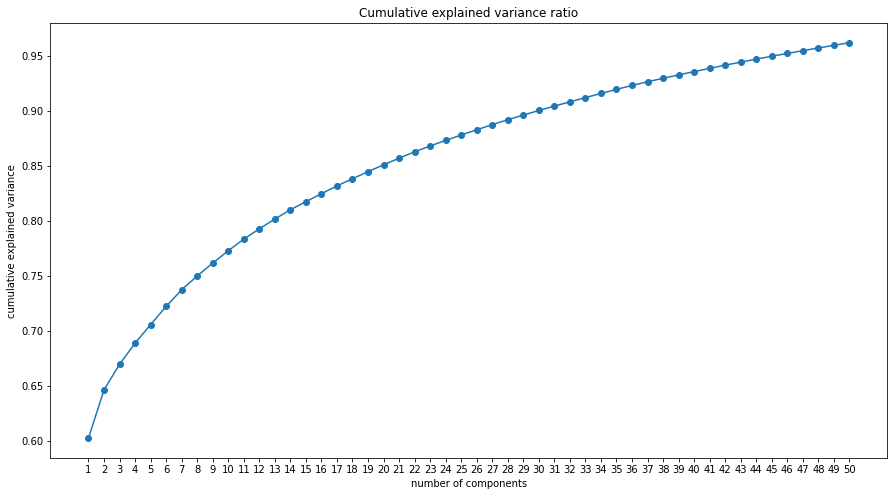

In [ ]:
ratio = pca_results[50]['var_ratio']
plt.figure(figsize=(15, 8))
plt.plot(np.arange(1,51,1),np.cumsum(ratio),'-o')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.title("Cumulative explained variance ratio")
plt.xticks(np.arange(1,51,1))
plt.show()
#seeing how data is explained with at least 20 components

In [ ]:
for k in pca_results.keys():
  var = pca_results[k]['var']
  print(var)

[238.15621062  17.25931774]
[238.15621062  17.25931774   9.20760592   7.57432591   6.68830526
   6.48434347   5.99561901   4.96603787   4.61677481   4.42379803]
[238.15621062  17.25931773   9.20760437   7.57432249   6.68825564
   6.48433699   5.99548174   4.96600888   4.61654332   4.42364292
   4.18165388   3.67774281   3.51016504   3.32463109   2.91073533
   2.85495014   2.7792326    2.56462449   2.5287363    2.4215023 ]
[238.15621062  17.25931774   9.20760593   7.57432595   6.68830578
   6.48434613   5.9956193    4.96606063   4.61680388   4.42388664
   4.18241208   3.67833208   3.51510774   3.32770913   2.92117488
   2.85990881   2.78073662   2.57825874   2.54419132   2.45451037
   2.3753733    2.29366445   2.09778232   2.00257374   1.93676949
   1.86231291   1.84723585   1.76827441   1.67675981   1.63667679
   1.57123459   1.53387989   1.5167874    1.49418944   1.46564311
   1.40780175   1.31819881   1.26186319   1.20253003   1.18440214
   1.16535892   1.14306223   1.09368157   1.07

0
1
2


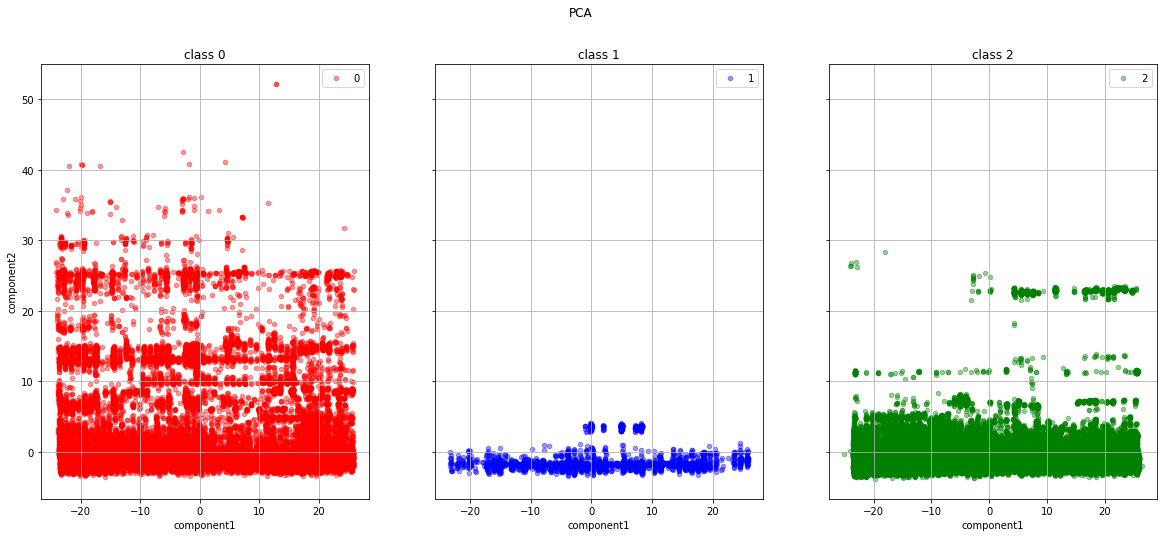

In [ ]:
classes = pd.DataFrame(orig_labels,columns=['class'])

pca2comp = pca_results[2]
pca_2_results = pca2comp['data'].merge(classes,left_index=True,right_index=True)

pca_2_results.rename(columns = {pca_2_results.columns[0]:'component1', pca_2_results.columns[1]:'component2'}, inplace = True)

fig,ax = plt.subplots(1, 3, sharex='col', sharey='row',figsize=(20, 8))

fig.suptitle('PCA')

mean2 = pca_2_results.mean(axis=0)
mean2[0],mean2[1]

grouped = pca_2_results.groupby('class')
colors=['red','blue','green']
count = 0
for key, group in grouped:
    print(key)
    axes = ax[count]
    group.plot(ax=axes, kind='scatter', x='component1', y='component2', label=key, color=colors[key], alpha = 0.4)
    count +=1
    axes.set_title(f"class {key}")
    axes.grid()
#ax.set_xscale('log')
#ax.set_yscale('log')  

plt.show()


## b.FAST ICA

In [ ]:

data_ICA = FastICA(random_state=0)
ICA_transform = data_ICA.fit_transform(train_features)

ICA_df = pd.DataFrame(data = ICA_transform)
ICA_kurtosis = ICA_df.kurt()


ICA_components = [2,10,20,50]
ICA_results = defaultdict(dict)

for ICA_comp in ICA_components :
  start = time.time()
  print(ICA_comp)
  _ICA = FastICA(n_components=ICA_comp,random_state=0)
  _ICA_data = _ICA.fit_transform(train_features)
  #print(_ICA.components_)
  _ICA_df = pd.DataFrame(data = _ICA_data)
  _data_ICA_df = pd.DataFrame(data = _ICA_data)
  kurt = _data_ICA_df.kurt()
  _data_ICA_df_labels = pd.concat([_data_ICA_df,pd.DataFrame(orig_labels,columns=['class'])],axis=1)
  end = time.time() - start
  ICA_results[ICA_comp] ={"data":_data_ICA_df_labels, "kurt":kurt,"time":{end},"comp":_ICA.components_ ,"mixing":_ICA.mixing_}
  
  kmeansdict = kmeanswrap(_data_ICA_df,orig_labels)
  emdict = emwrap(_data_ICA_df,orig_labels)

  ICA_results[ICA_comp] ={"data":_data_ICA_df_labels, "kurt":kurt,"time":{end},"comp":_ICA.components_ ,"mixing":_ICA.mixing_,
                          "kmean":kmeansdict,
                          "em":emdict}

root_path = '/content/drive/MyDrive/Archi_Dataset/Data'
pckpath = os.path.join(root_path,"dataset_a_ica.pickle")
with open(pckpath, 'wb') as handle:
    pickle.dump(ICA_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

2
2
5
10
20
2
5
10
20
10
2
5
10
20
2
5
10
20
20
2
5
10
20
2
5
10
20
50
2
5
10
20
2
5
10
20


In [ ]:
ICA_kurtosis

0      5684.063685
1        27.671974
2         1.268858
3      1375.442211
4        11.766906
          ...     
161    4589.434858
162     964.283861
163    4147.122614
164       3.238050
165      33.247049
Length: 166, dtype: float64

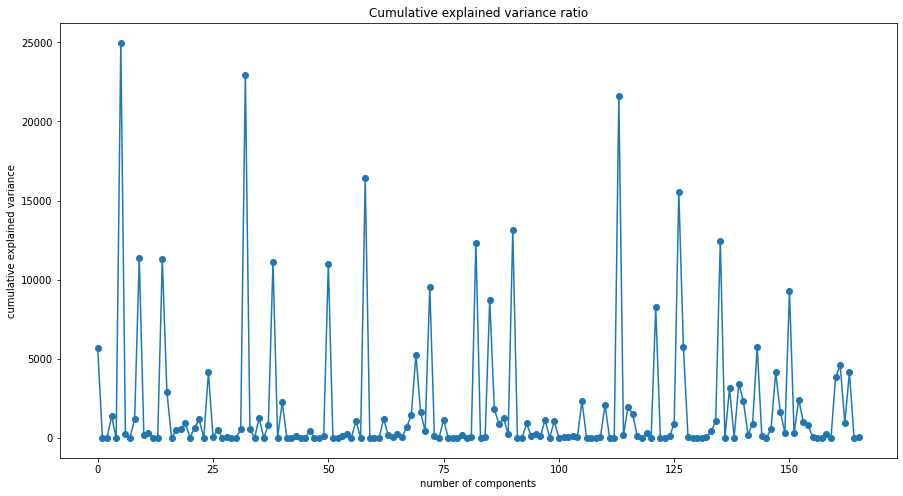

In [ ]:
#kurtosis
plt.figure(figsize=(15, 8))
plt.plot(ICA_kurtosis,'-o')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.title("Cumulative explained variance ratio")

plt.show()

In [ ]:
ICA_results[2]['data']

,0,1,class
0,-0.003496,0.000182,2
1,0.002584,0.000115,0
2,-0.001425,-0.002740,0
3,0.003364,-0.000351,2
4,-0.003512,-0.000029,2
...,...,...,...
203764,-0.000617,0.000724,2
203765,-0.000246,-0.000004,2
203766,-0.000246,-0.000005,2
203767,-0.000254,0.000016,2


0
1
2


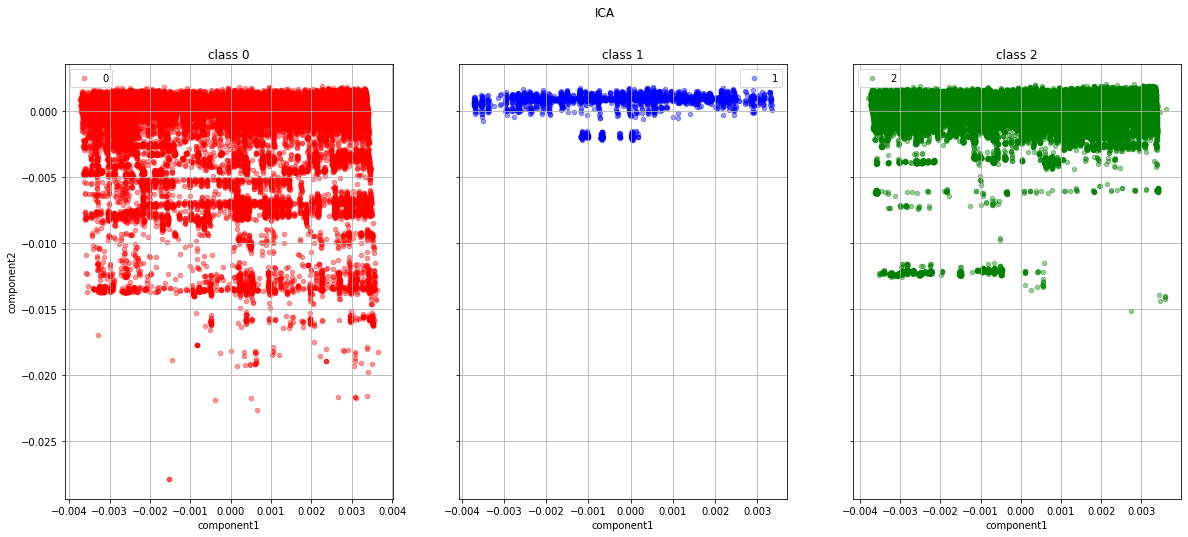

In [ ]:
classes = pd.DataFrame(orig_labels,columns=['class'])

ica2comp = ICA_results[2]['data']

ica2comp.rename(columns = {ica2comp.columns[0]:'component1', ica2comp.columns[1]:'component2'}, inplace = True)

fig,ax = plt.subplots(1, 3, sharex='col', sharey='row',figsize=(20, 8))

fig.suptitle('ICA')

mean2 = ica2comp.mean(axis=0)
mean2[0],mean2[1]

grouped = ica2comp.groupby('class')
colors=['red','blue','green']
count = 0
for key, group in grouped:
    print(key)
    axes = ax[count]
    group.plot(ax=axes, kind='scatter', x='component1', y='component2', label=key, color=colors[key], alpha = 0.4)
    count +=1
    axes.set_title(f"class {key}")
    axes.grid()
#ax.set_xscale('log')
#ax.set_yscale('log')  

plt.show()

In [ ]:
comp2 = ICA_results[1]
results = comp2['kurt']
results[0]

-1.3959492017024078

In [ ]:
for i in ICA_results.keys():
  print(ICA_results[i]['kurt'])

0   -1.395949
dtype: float64
0   -1.364913
1    7.192080
dtype: float64
0    123.436196
1     86.845220
2     -1.363585
dtype: float64
0      -1.329957
1      16.576885
2    6498.748635
3      12.385435
dtype: float64
0      -1.337514
1      20.202834
2       2.788673
3      15.166015
4      34.927428
5    8723.389459
dtype: float64
0    9758.473214
1      33.129878
2       2.705253
3      -1.331278
4      20.927428
5      16.861458
6      35.585440
7      45.032370
dtype: float64


[-1.3959492017024078, 2.9135834958920745, 69.63927710198654, 1631.5952495178926, 1465.856149249226, 1238.9229702363111]


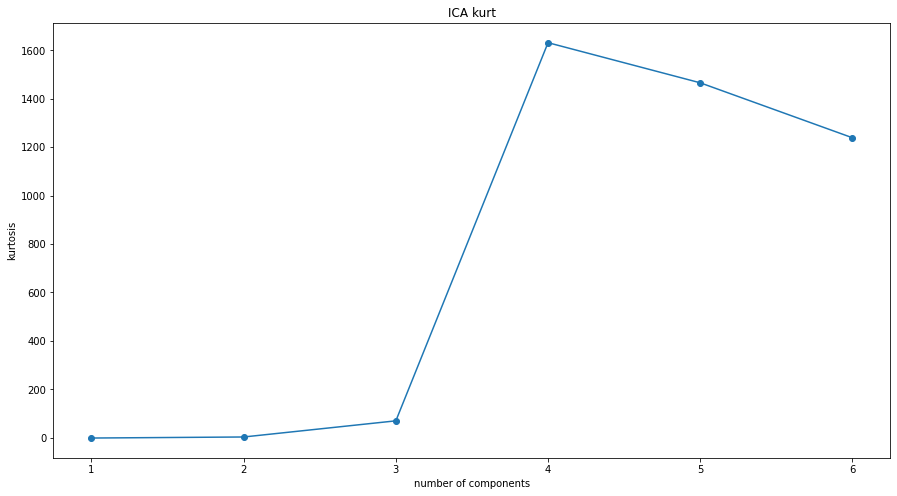

In [ ]:
kurts = []
for i in ICA_results.keys():
  
  kurts.append(np.mean((ICA_results[i]['kurt'])))

xticks = np.arange(1,len(kurts)+1)
#kurtosis
print(kurts)
plt.figure(figsize=(15, 8))
plt.plot(xticks,kurts,'-o')
plt.xlabel('number of components')
plt.ylabel('kurtosis')
plt.xticks(xticks)
plt.title("ICA kurt")
#plt.yscale('symlog')
plt.show()

## c. RP (randomized projection)

In [ ]:
RP_components = [2,10,20,50]
NN_RP_score = defaultdict(dict)
my_accuracy_kmeans_RP = defaultdict(dict)
my_time_kmeans_RP = defaultdict(dict)
my_accuracy_em_RP = defaultdict(dict)
my_time_em_RP = defaultdict(dict)



RP =GaussianRandomProjection(random_state=0,n_components=11)
RP_data = RP.fit_transform(train_features)
RP_df = pd.DataFrame(data = RP_data)
RP_kurtosis = RP_df.kurt()

rp_results = defaultdict(dict)

for RP_comp in RP_components:
  start = time.time()
  _data_RP = GaussianRandomProjection(n_components=RP_comp,random_state=0)
  _data_RP_data = _data_RP.fit_transform(train_features)
  _data_RP_df = pd.DataFrame(data = _data_RP_data)
  _RP_kurtosis = RP_df.kurt()
  _data_RP_df_label = pd.concat([_data_RP_df,pd.DataFrame(orig_labels,columns=['class'])],axis=1)
  end = time.time() - start

  kmeansdict = kmeanswrap(_data_RP_df,orig_labels)
  emdict = emwrap(_data_RP_df,orig_labels)

  rp_results[RP_comp] ={"data":_data_RP_df_label,"time":{end},"comp":_data_RP.components_ ,
                          "kmean":kmeansdict,
                          "em":emdict}


root_path = '/content/drive/MyDrive/Archi_Dataset/Data'
pckpath = os.path.join(root_path,"dataset_a_rp.pickle")
with open(pckpath, 'wb') as handle:
    pickle.dump(rp_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
  

2
5
10
20
2
5
10
20
2
5
10
20
2
5
10
20
2
5
10
20
2
5
10
20
2
5
10
20
2
5
10
20


In [ ]:
rp_results

In [ ]:
rp_results[2]['data']

,0,1,class
0,50.491491,-36.044262,2
1,6.013220,-2.344858,0
2,25.670433,-26.637358,0
3,-0.489483,5.491858,2
4,76.611412,-24.296555,2
...,...,...,...
203764,31.468533,-19.720013,2
203765,61.431194,52.531600,2
203766,61.503842,52.486836,2
203767,62.126052,52.850307,2


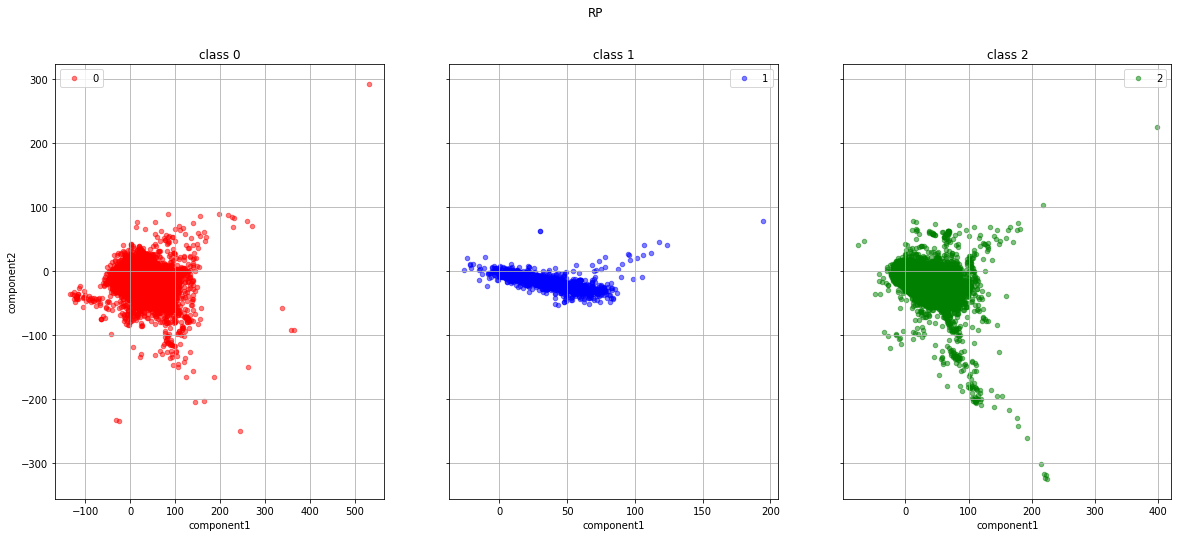

In [ ]:

def plot_comp(comp2,title):
  results = comp2['data']

  results.rename(columns = {results.columns[0]:'component1', results.columns[1]:'component2'}, inplace = True)

  xlim = [results['component1'].min(),results['component1'].min()]
  ylim = [results['component2'].min(),results['component2'].max()]

  fig,ax = plt.subplots(1,3, sharex='col', sharey='row',figsize=(20, 8))

  fig.suptitle(title)

  mean2 = results.mean(axis=0)
  mean2[0],mean2[1]

  grouped = results.groupby('class')
  colors=['red','blue','green']
  count = 0
  for key, group in grouped:
      axes = ax[count]
      group.plot(ax=axes, kind='scatter', x='component1', y='component2', label=key, xlim=xlim,ylim=ylim, color=colors[key], alpha = 0.5)
      count +=1
      axes.set_title(f"class {key}")
      axes.grid()
  #ax.set_xscale('log')
  #ax.set_yscale('log')  

  plt.show()

In [ ]:
plot_comp(rp_results[2],'RP')

# d. RFE (recursive feature elimination)

In [ ]:
RFE_component = [1,2,3,4,6,8]
NN_RFE_score = defaultdict(dict)
estimator = SVR(kernel="linear")
my_accuracy_kmeans_RFE = defaultdict(dict)
my_time_kmeans_RFE = defaultdict(dict)
my_accuracy_em_RFE = defaultdict(dict)
my_time_em_RFE = defaultdict(dict)

rfe_results = defaultdict(dict)
for RFE_comp in RFE_component :
  start = time.time()
  _data_RFE = RFE(estimator,n_features_to_select=RFE_comp)
  _data_RFE_data = _data_RFE.fit_transform(train_features,orig_labels)
  _data_RFE_df = pd.DataFrame(data = _data_RFE_data)
  _data_RFE_df = pd.concat([_data_RFE_df,orig_labels],axis=1)
  end = time.time() -start
  rfe_results[RP_comp] ={"data":_data_RFE_df , "time":{end}}

In [ ]:
comp2 = rfe_results[2]
results = comp2['data']

results.rename(columns = {results.columns[0]:'component1', results.columns[1]:'component2'}, inplace = True)

fig,ax = plt.subplots(1, 2, sharex='col', sharey='row',figsize=(15, 8))

fig.suptitle('RP')

mean2 = results.mean(axis=0)
mean2[0],mean2[1]

grouped = results.groupby('class')

count = 0
for key, group in grouped:
    axes = ax[count]
    group.plot(ax=axes, kind='scatter', x='component1', y='component2', label=key, color=colors[key], alpha = 0.5)
    count +=1
    axes.set_title(f"class {key}")
    axes.grid()
#ax.set_xscale('log')
#ax.set_yscale('log')  

plt.show()

# 04-NeuralNets

## a. GCN baseline

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.nn import Linear, LayerNorm, ReLU, Dropout
import torch.nn.functional as F
from torch_geometric.nn import ChebConv, NNConv, DeepGCNLayer, GATConv, DenseGCNConv, GCNConv, GraphConv
from torch_geometric.data import Data, DataLoader

from sklearn.metrics import roc_auc_score
import scipy.sparse as sp

import warnings
warnings.filterwarnings("ignore")

In [ ]:
y_train = labels[classified_idx]

# spliting train set and validation set
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid, train_idx, valid_idx = train_test_split(node_features[classified_idx], y_train, classified_idx, test_size=0.15, random_state=42, stratify=y_train)

In [ ]:
num_inputs= data_train.x.shape[1]
num_inputs


166

In [ ]:
data_train.y[classified_idx].sum()

tensor(4545., dtype=torch.float64)

In [ ]:
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
class Net(torch.nn.Module):
    def __init__(self,inputs):
        super(Net, self).__init__()
        
        self.conv1 = GCNConv(inputs, 128)
        self.conv2 = GCNConv(128, 128)
        self.conv3 = GCNConv(64, 64)
        self.conv4 = GCNConv(128, 1) 

    def forward(self, data, adj=None):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.conv4(x, edge_index)

        return F.sigmoid(x)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Net().to(device)

model.double()
data_train = data_train.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.BCELoss()

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data_train)
    # data_train.y.unsqueeze(1)
    out = out.reshape((data_train.x.shape[0]))
    
    loss = criterion(out[train_idx], data_train.y[train_idx])
    auc = roc_auc_score(data_train.y.detach().cpu().numpy()[train_idx], out.detach().cpu().numpy()[train_idx]) #[train_idx]
    loss.backward()
    optimizer.step()
    if epoch%5 == 0:
      print("epoch: {} - loss: {} - roc: {}".format(epoch, loss.item(), auc))

RuntimeError: ignored

In [ ]:
preds = model(data_train)
preds = preds.detach().cpu().numpy()

In [ ]:
from sklearn.metrics import accuracy_score
out_labels = preds > 0.6
train_acc = accuracy_score(data_train.y.detach().cpu().numpy()[train_idx], out_labels[train_idx])
train_auc = roc_auc_score(data_train.y.detach().cpu().numpy()[train_idx], preds[train_idx])
print("train accuracy: ", train_acc)
print("train AUC: ", train_auc)

train accuracy:  0.9555319740266303
train AUC:  0.9654929501514913


In [ ]:
valid_auc = roc_auc_score(data_train.y.detach().cpu().numpy()[valid_idx], preds[valid_idx])
out_labels = out.detach().cpu().numpy() > 0.6
valid_acc = accuracy_score(data_train.y.detach().cpu().numpy()[valid_idx], out_labels[valid_idx])
print("valid accuracy: ", valid_acc)
print("valid AUC: ", valid_auc)

valid accuracy:  0.9539012168933428
valid AUC:  0.9526509044941129


In [ ]:
# total predicted illicit (positives) in test set
out_labels[unclassified_idx].sum()

10867

In [ ]:
out_labels[valid_idx]

array([False, False, False, ..., False, False, False])

In [ ]:
# total predicted positives in validation set
out_labels[valid_idx].sum()

496

In [ ]:
from sklearn.metrics import roc_curve, confusion_matrix
# confusion matrix for validation data
cm = confusion_matrix(data_train.y.detach().cpu().numpy()[valid_idx], out_labels[valid_idx])
cm

array([[6235,   68],
       [ 254,  428]])

In [ ]:
# confusion matrix for train data
cm = confusion_matrix(data_train.y.detach().cpu().numpy()[train_idx], out_labels[train_idx])
cm

array([[35461,   255],
       [ 1489,  2374]])